In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import os
import os.path as osp
from tqdm import tqdm
import shutil 
import sys
import argparse
import pickle
from collections import OrderedDict

from utils import *
from models import *

import matplotlib.pyplot as plt

In [2]:
gpu_id='0'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  0


## load model

In [3]:
def select_model(model_name):
    if model_name=='deeponet':
        return deeponet
    elif model_name=='shiftdeeponet':
        return shiftdeeponet
    elif model_name=='flexdeeponet':
        return flexdeeponet
    elif model_name=='NOMAD':
        return NOMAD
    elif model_name=='hyperdeeponet':
        return hyperdeeponet

In [4]:
def load_model(model, state_dict):
    if args.multgpu:
        new_keys = []
        for key in state_dict.keys():
            new_key = key[7:]    # remove the 'module.'
            new_keys.append(new_key)
        new_values = OrderedDict(list(zip(new_keys, state_dict.values())))
        model.load_state_dict(new_values)
        print('multi gpu model is loaded')
    else:
        model.load_state_dict(state_dict)
        print('single gpu model is loaded')
    return model

In [5]:
name = 'SIRv2_121_DeepONet_mse'

In [6]:
path=os.path.join('results',name)
args=torch.load(os.path.join(path,'args.bin'))
state_dict=torch.load(os.path.join(path,'weight.bin'))
loss_dict=torch.load(os.path.join(path,'loss.bin'))
model_name = 'small '+args.model if 'small' in name else args.model
args

Namespace(a_hyper='tanh', a_target='tanh', batch=20000, d_hyper=2, d_in=1, d_out=2, d_target=2, data='SIR_v2', epochs=20000, gamma=0.0005, gpu_idx=0, load_path=None, lr=0.001, model='deeponet', multgpu=False, n_basis=10, n_sensor=121, name='SIRv2_121_DeepONet_rel2', sche_type='inversetime', seed=1, step_size=1, w_hyper=20, w_target=20, wd=0.0)

In [7]:
model=select_model(args.model)(
                args.d_target,
                args.w_target,
                args.a_target,
                args.d_hyper,
                args.w_hyper,
                args.a_hyper,    
                args.n_sensor,
                args.d_in,
                args.n_basis,
                args.d_out
            ).cuda()
model = load_model(model, state_dict)

single gpu model is loaded


In [8]:
for k,v in model.named_parameters():
    v.requires_grad=False

In [9]:
for k,v in model.named_parameters():
    print(k,v)
    break

trunk_list.0.weight Parameter containing:
tensor([[ 0.9201],
        [-1.3239],
        [-0.8311],
        [ 0.8055],
        [-1.7355],
        [ 0.9117],
        [-0.3973],
        [ 1.1216],
        [ 0.5346],
        [-0.5871],
        [ 0.7471],
        [-0.1575],
        [ 0.4237],
        [-1.2487],
        [-0.3640],
        [-0.0485],
        [ 1.0501],
        [ 0.2277],
        [ 1.8543],
        [ 0.6186]], device='cuda:0')


## phase 2

In [155]:
T = 30
M = args.n_sensor # sensor 개수
D = np.linspace(0, T, M)
#c1,c2,c3 = 1e-6,1e-6,1
c1,c2,c3 = 1e-3,1e-2,1

lr = 1e-3
num_iter = 20000

In [156]:
sensor_D = torch.tensor(D).float().cuda()

#torch.manual_seed(42)
#sensor_u = torch.rand(M).cuda()

torch.manual_seed(42)
sensor_u = torch.tensor([0.5]*M).cuda()

In [157]:
def viz(iteration,sensor_u):
    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)
    with torch.no_grad():
        pred=model(test_x[:,M:],test_x[:,:M]).detach().cpu()

    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 1)  
    #plt.plot(xnew, ynew,'--',color='gray')
    plt.plot(D, sensor_u.detach().cpu().numpy(), 'o',color='red',markersize=3)
    plt.xlabel('t')
    plt.title('[iter : %d] u(t)'%iteration)

    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 2)  
    #plt.plot(D, y[:,0],label='ode solver',markersize=3)
    plt.plot(D, pred[:,0],'--',markersize=3)
    plt.title('[iter : %d] S(t)'%iteration)
    plt.xlabel('t')

    plt.figure(figsize=(10,7))
    plt.subplot(3, 1, 3)  
    #plt.plot(D, y[:,1],label='ode solver',markersize=3)
    plt.plot(D, pred[:,1],'--',markersize=3)
    plt.title('[iter : %d] I(t)'%iteration)
    plt.xlabel('t')
    plt.show()

    # print('res S :',rel_L2_error(pred[:,0],y[:,0]).item())
    # print('res I :',rel_L2_error(pred[:,1],y[:,1]).item())

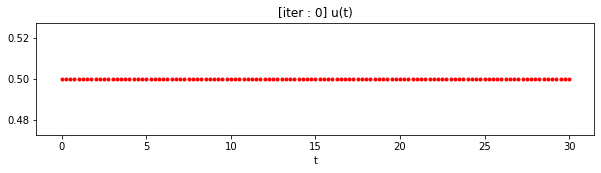

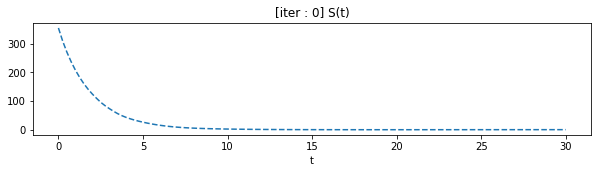

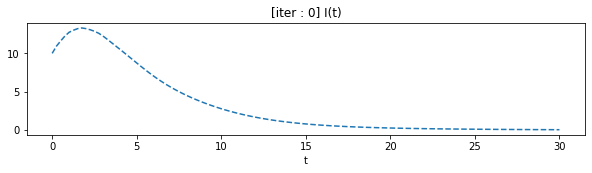

In [158]:
## check init ##
viz(0,sensor_u)

  0%|                                                                                        | 0/20001 [00:00<?, ?it/s]

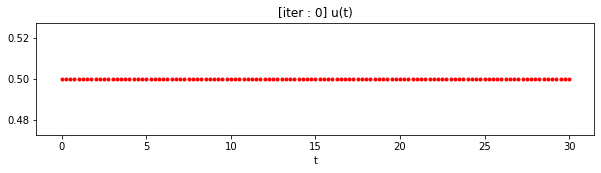

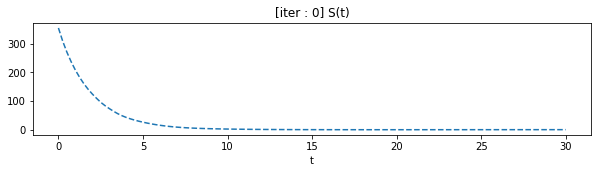

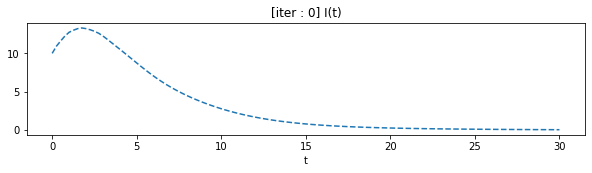

[iter : 999]:   5%|██▉                                                            | 936/20001 [00:01<01:39, 191.32it/s]

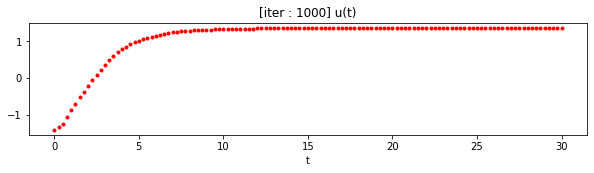

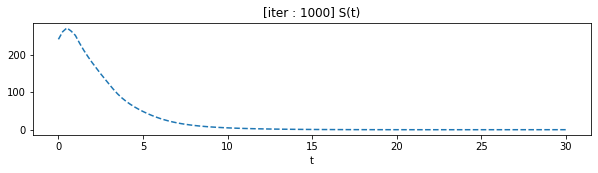

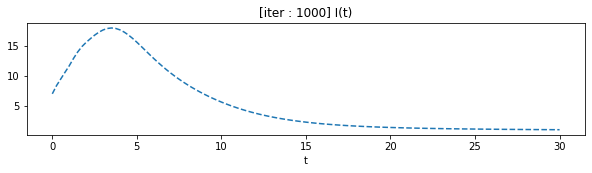

[iter : 1999]:  10%|█████▉                                                       | 1930/20001 [00:03<00:26, 693.00it/s]

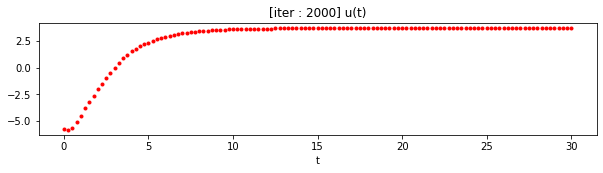

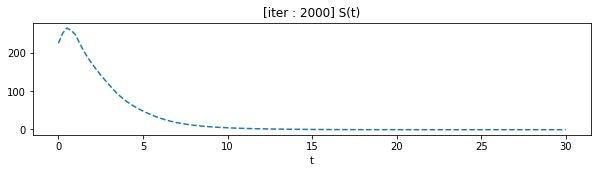

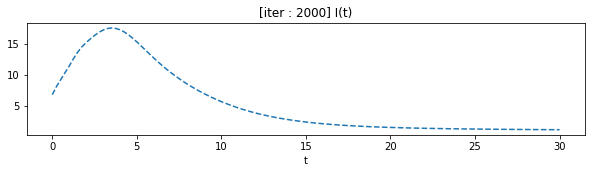

[iter : 2999]:  15%|████████▉                                                    | 2946/20001 [00:04<00:22, 767.84it/s]

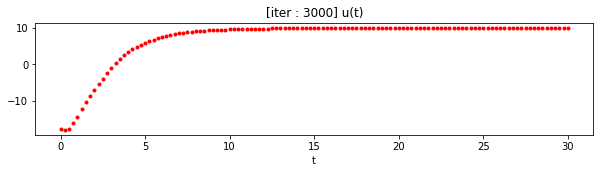

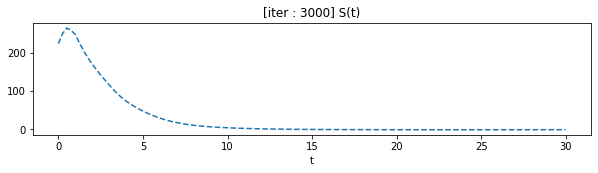

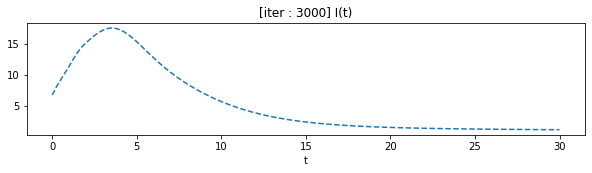

[iter : 3999]:  20%|████████████                                                 | 3948/20001 [00:06<00:21, 752.20it/s]

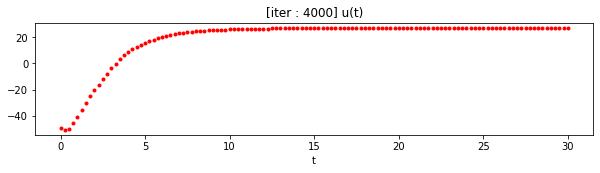

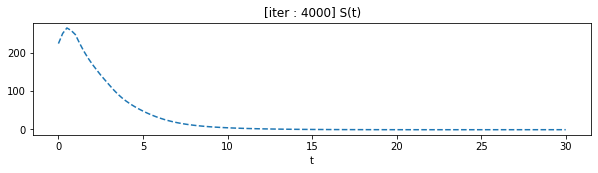

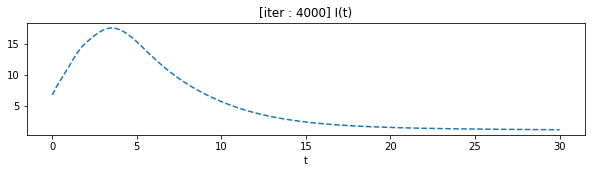

[iter : 4999]:  25%|███████████████▏                                             | 4962/20001 [00:07<00:19, 763.85it/s]

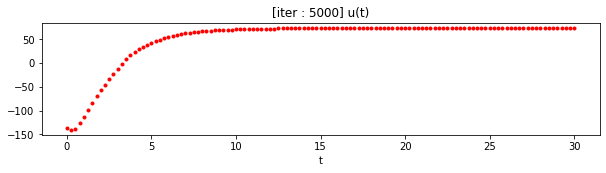

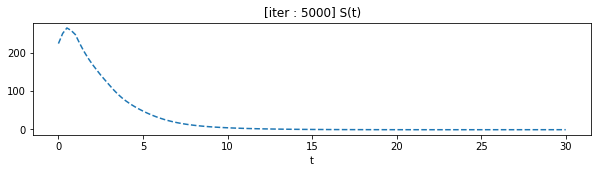

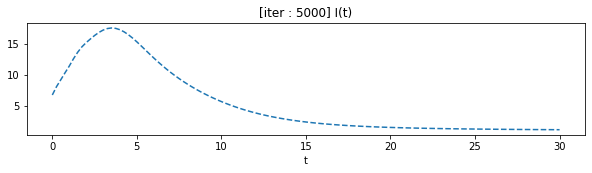

[iter : 5999]:  30%|██████████████████▎                                          | 5985/20001 [00:09<00:18, 764.15it/s]

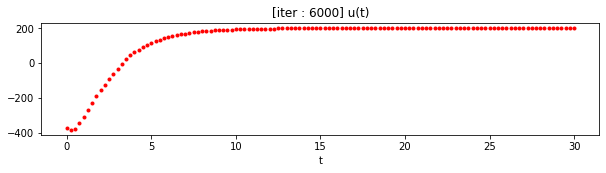

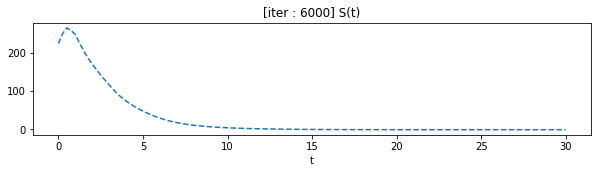

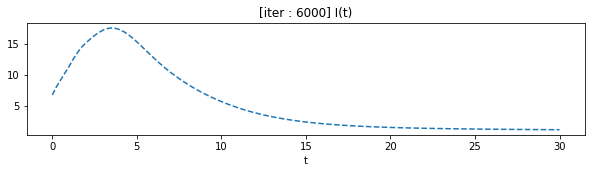

[iter : 6999]:  35%|█████████████████████▎                                       | 6995/20001 [00:11<00:17, 763.54it/s]

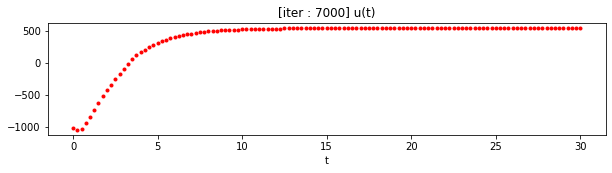

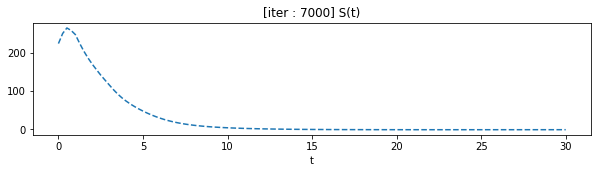

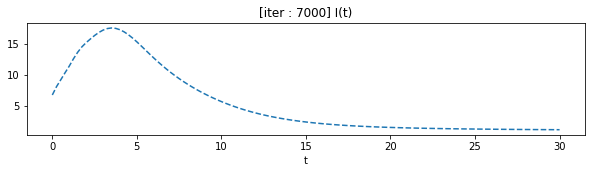

[iter : 7999]:  40%|████████████████████████▍                                    | 7997/20001 [00:12<00:15, 750.76it/s]

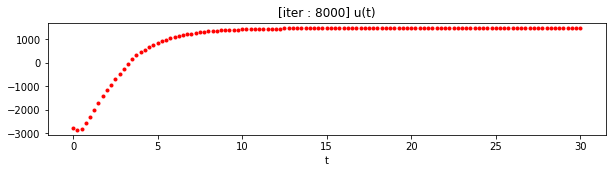

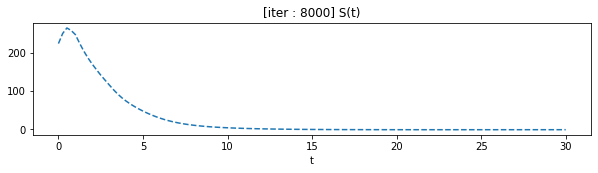

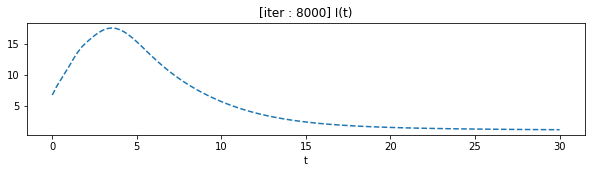

[iter : 8999]:  45%|███████████████████████████▏                                 | 8931/20001 [00:14<00:15, 735.46it/s]

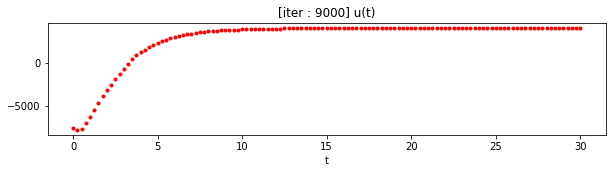

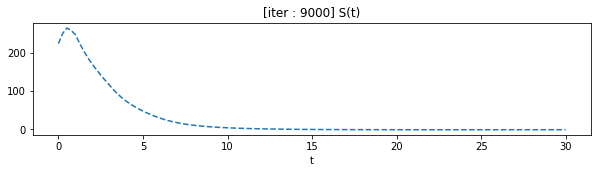

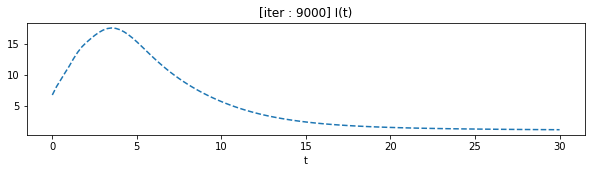

[iter : 9999]:  50%|██████████████████████████████▎                              | 9940/20001 [00:16<00:13, 764.88it/s]

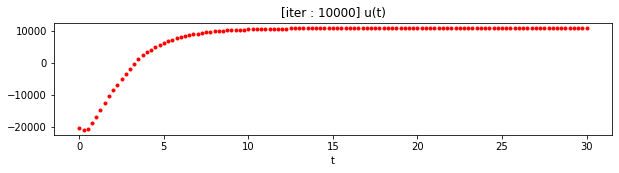

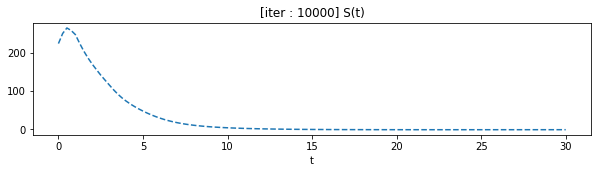

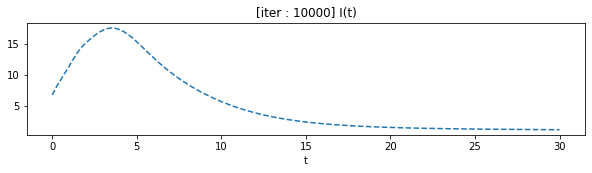

[iter : 10999]:  55%|████████████████████████████████▎                          | 10944/20001 [00:17<00:11, 767.88it/s]

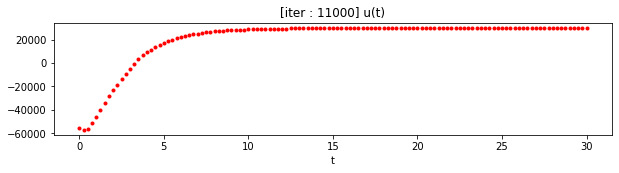

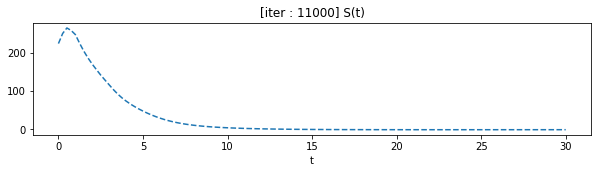

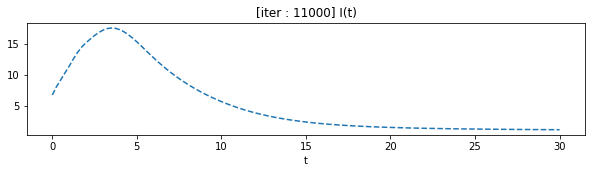

[iter : 11999]:  60%|███████████████████████████████████▎                       | 11958/20001 [00:19<00:10, 762.59it/s]

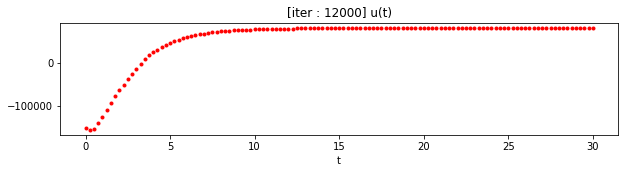

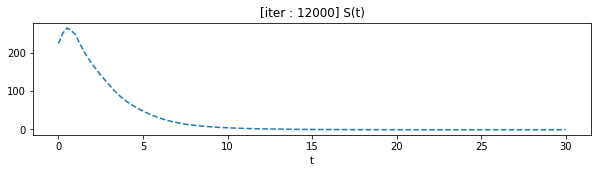

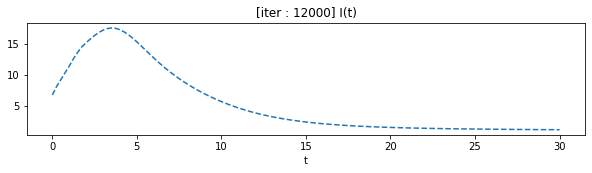

[iter : 12999]:  65%|██████████████████████████████████████▏                    | 12956/20001 [00:20<00:09, 773.89it/s]

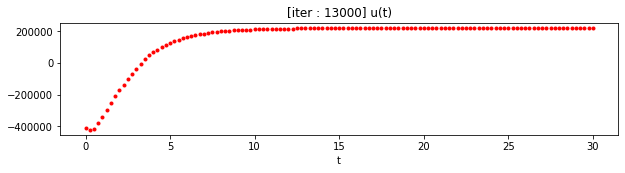

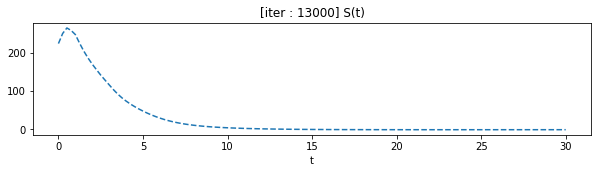

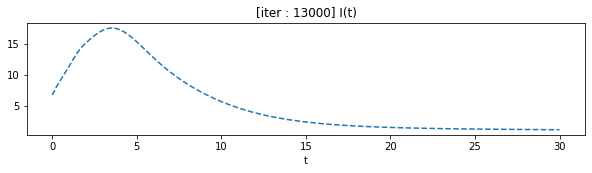

[iter : 13999]:  70%|█████████████████████████████████████████▏                 | 13948/20001 [00:22<00:08, 727.67it/s]

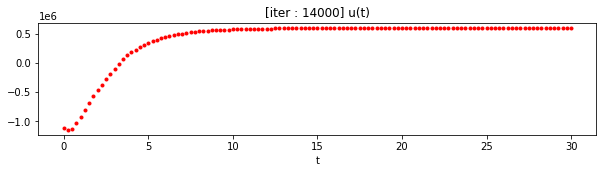

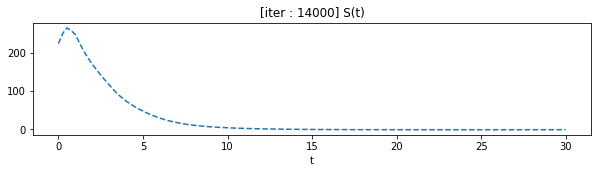

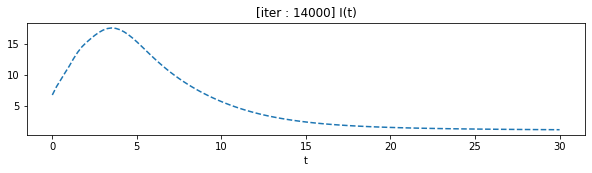

[iter : 14458]:  72%|██████████████████████████████████████████▋                | 14459/20001 [00:23<00:08, 618.65it/s]


KeyboardInterrupt: 

In [159]:
#
#u = PolynomialModel(degree).cuda()
#u = LinearModel([5,5,5]).cuda()
#optimizer=torch.optim.Adam(u.parameters(), lr=lr, weight_decay=w_decay)

## for viz ##
#xnew = np.linspace(0, T, 10*M)
#Dnew = torch.tensor(xnew).float().cuda()
###

model.eval()
pbar = tqdm(range(num_iter+1),position=0, leave=True,file=sys.stdout)
losses = []
result = {}
loss = 0
for iteration in pbar: 
    if iteration % 1000 == 0:
#         u = sensor_u.detach().cpu().numpy()
#         plt.figure(figsize=(10,7))
#         plt.subplot(3, 1, 1)  
#         plt.plot(D , u, 'o', markersize=3)
#         plt.xlabel('t')
#         plt.ylim(0,1.1)
#         plt.title("u(t) (iter : %d, loss : %f)"%(iteration,loss))
        viz(iteration,sensor_u)
        result[iteration] = sensor_u.detach().cpu().numpy()
        plt.show()
        
    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)

    # test_x = []
    # for j in D:
    #     test_x.append(np.append(sensor_u, j))
    # test_x = torch.as_tensor(test_x).reshape(-1, len(D) + 1).float()

    pred=model(test_x[:,M:],test_x[:,:M])

    sensor_s = pred[:,0]
    sensor_i = pred[:,1]
    
    #sensor_u = sensor_u - lr*(c2*sensor_s+2*c3*sensor_u)
    #sensor_u = sensor_u - lr*(sensor_u-(c2*sensor_s)/(2*c3)) 
    
    ###
    #sensor_u = -(c2*sensor_s)/(2*c3) 
    #sensor_u = sensor_u - lr*(-(c2*sensor_s)/(2*c3))
    
    pbar.set_description("[iter : %d]"%(iteration))
    #losses.append(loss.item())
    
    

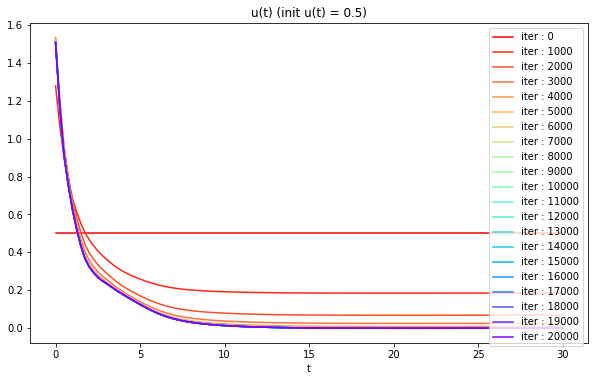

In [153]:
plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)  

colors = plt.cm.rainbow(np.linspace(1,0, len(result))) 
for i,(k,v) in enumerate(result.items()):
    plt.plot(D, v,color=colors[i], label = 'iter : '+str(k))
#plt.plot(D, x, 'o',color='red',markersize=3)
plt.xlabel('t')
#plt.ylim(0,1)
#plt.title("u(t) {degree :%d}"%(degree))
plt.title("u(t) (init u(t) = 0.5)")
plt.legend()

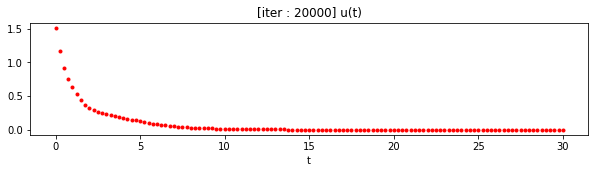

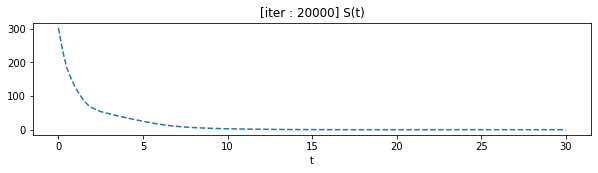

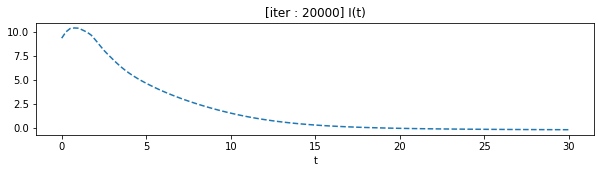

In [154]:
viz(num_iter,sensor_u)

In [147]:
c2

0.01

### 잘못된 ver

In [46]:
class LinearModel(nn.Module):
    def __init__(self, layer_dims, act = 'relu'):
        super().__init__()
        if act == 'relu':
            self.act = nn.ReLU()
        self.block = lambda d_in,d_out : nn.Sequential(nn.Linear(d_in, d_out),self.act)
        layer_dims = [1]+layer_dims
        layer = []
        for i in range(len(layer_dims)-1):
            layer.append(self.block(layer_dims[i],layer_dims[i+1]))
        layer.append(nn.Linear(layer_dims[-1],1))
        self.layer = nn.Sequential(*layer)
    def forward(self, x):
        x = self.layer(x.view(-1,1)).view(-1)
        return torch.clamp(x,min=0,max=1)

In [47]:
class PolynomialModel(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self._degree = degree
        self.linear = nn.Linear(self._degree, 1)
        init.constant_(self.linear.weight, 0)
        init.constant_(self.linear.bias, 1)

    def forward(self, x):
        x = self.linear(self._polynomial_features(x))
        #return x
        return torch.clamp(x,min=0,max=1) # x
        

    def _polynomial_features(self, x):
        x = x.unsqueeze(1)
        return torch.cat([x ** i for i in range(1, self._degree + 1)], 1)

In [48]:
T = 30
M = args.n_sensor # sensor 개수
D = np.linspace(0, T, M)
c1 = 1e-6
c2 = 1e-6
c3 = 1

lr = 1e-4
w_decay = 0
num_iter = 20000
degree = 10

  0%|                                                                                        | 0/20001 [00:00<?, ?it/s]

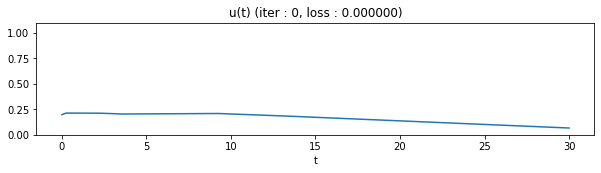

[iter : 999] loss : 0.009358:   5%|██▎                                            | 981/20001 [00:04<01:14, 256.36it/s]

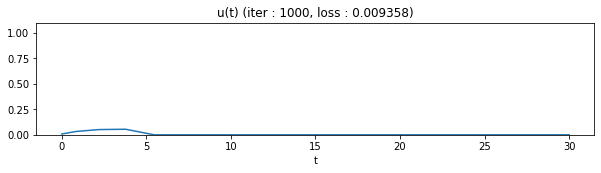

[iter : 1999] loss : 0.000131:  10%|████▍                                        | 1976/20001 [00:08<01:14, 241.50it/s]

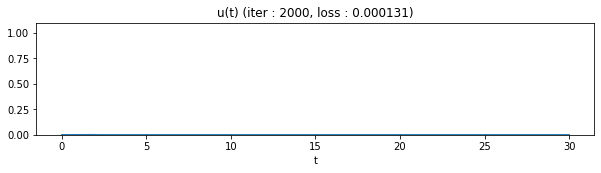

[iter : 2565] loss : 0.000131:  13%|█████▊                                       | 2565/20001 [00:10<01:13, 236.67it/s]


KeyboardInterrupt: 

In [51]:
sensor_D = torch.tensor(D).float().cuda()
#u = PolynomialModel(degree).cuda()
u = LinearModel([5,5,5]).cuda()
optimizer=torch.optim.Adam(u.parameters(), lr=lr, weight_decay=w_decay)

## for viz ##
xnew = np.linspace(0, T, 10*M)
Dnew = torch.tensor(xnew).float().cuda()
###

model.eval()
pbar = tqdm(range(num_iter+1),position=0, leave=True,file=sys.stdout)
losses = []
result = {}
loss = 0
for iteration in pbar: 
    if iteration % 1000 == 0:
        u.eval()
        with torch.no_grad():
            pred = u(Dnew).view(-1).cpu().numpy()
        plt.figure(figsize=(10,7))
        plt.subplot(3, 1, 1)  
        plt.plot(xnew, pred)
        plt.xlabel('t')
        plt.ylim(0,1.1)
        plt.title("u(t) (iter : %d, loss : %f)"%(iteration,loss))
        result[iteration] = pred
        plt.show()
        
    u.train()
    sensor_u = u(sensor_D).squeeze(-1)
    # sensor_u = torch.arange(10)
    # sensor_D = torch.arange(M)
    # torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)

    test_x = torch.cat((sensor_u.repeat(M,1), sensor_D.view(M,1)), dim=1)

    # test_x = []
    # for j in D:
    #     test_x.append(np.append(sensor_u, j))
    # test_x = torch.as_tensor(test_x).reshape(-1, len(D) + 1).float()

    pred=model(test_x[:,M:],test_x[:,:M])

    sensor_s = pred[:,0]
    sensor_i = pred[:,1]

    #dJ_du = c2*sensor_s+ 2*c3*sensor_u
    loss = torch.trapz(c1*sensor_i+c2*sensor_u*sensor_s+c3*sensor_u**2, sensor_D)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description("[iter : %d] loss : %f"%(iteration,loss))
    losses.append(loss.item())
    
    

## visualize

Text(0.5, 1.0, 'u(t)')

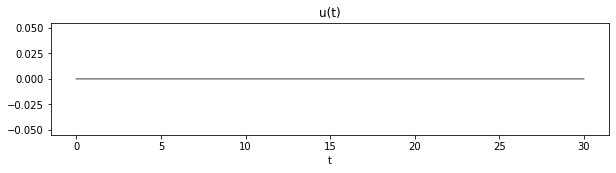

In [24]:
## 1개 viz ##
u.eval()
xnew = np.linspace(0, T, 10*M)
Dnew = torch.tensor(xnew).float().cuda() # for viz
with torch.no_grad():
    pred = u(Dnew).view(-1).cpu().numpy()

plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)  
plt.plot(xnew, pred,color='gray')
#plt.plot(D, x, 'o',color='red',markersize=3)
plt.xlabel('t')
#plt.ylim(0,1)
plt.title('u(t)')

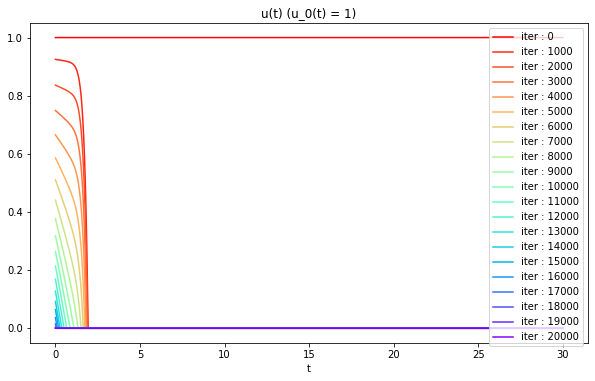

In [26]:
plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)  

colors = plt.cm.rainbow(np.linspace(1,0, len(result))) 
for i,(k,v) in enumerate(result.items()):
    plt.plot(xnew, v,color=colors[i], label = 'iter : '+str(k))
#plt.plot(D, x, 'o',color='red',markersize=3)
plt.xlabel('t')
#plt.ylim(0,1)
#plt.title("u(t) {degree :%d}"%(degree))
plt.title("u(t) (u_0(t) = 1)")
plt.legend()